In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

# Review data

In [2]:
path_review = (
    "/home/longnt70/libs/graph/amazon-dataset/AMAZON_FASHION_ALL_DATA.json.gz"
)

In [3]:
import pandas as pd
import gzip


def parse(path):
    g = gzip.open(path, "rb")
    for l in g:
        yield json.loads(l)


def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")


df = getDF(path_review)

In [4]:
df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN


In [5]:
df["reviewTime_date"] = pd.to_datetime(df["reviewTime"], format="%m %d, %Y")

In [6]:
usecols = [
    "overall",
    "verified",
    "reviewTime",
    "reviewerID",
    "asin",
    "reviewerName",
    "reviewText",
    "summary",
    "unixReviewTime",
]

In [7]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image', 'reviewTime_date'],
      dtype='object')

In [8]:
df.shape

(883636, 13)

# Metadata

In [9]:
path_metadata = (
    "/home/longnt70/libs/graph/amazon-dataset/meta_AMAZON_FASHION.json.gz"
)

In [10]:
### remove rows with unformatted title (i.e. some 'title' may still contain html style content)
def clean_review_data(df_review):
    df_review = df_review.fillna("")
    df_review = df_review[
        ~df_review["title"].str.contains("getTime")
    ]  # filter those unformatted rows
    return df_review

In [11]:
df_meta_data = getDF(path_metadata)
df_meta_data = clean_review_data(df_meta_data)
df_meta_data.head(1)

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,,,,,,,,


In [12]:
df_meta_data.columns

Index(['title', 'brand', 'feature', 'rank', 'date', 'asin', 'imageURL',
       'imageURLHighRes', 'description', 'price', 'also_view', 'also_buy',
       'fit', 'details', 'similar_item', 'tech1'],
      dtype='object')

# Prepare data

In [13]:
n_users = df.reviewerID.unique().shape[0]
n_movies = df.asin.unique().shape[0]
n_ratings = len(df)
avg_ratings_per_user = n_ratings / n_users

print("Number of unique users: ", n_users)
print("Number of unique movies: ", n_movies)
print("Number of total ratings: ", n_ratings)
print("Average number of ratings per user: ", avg_ratings_per_user)

Number of unique users:  749233
Number of unique movies:  186189
Number of total ratings:  883636
Average number of ratings per user:  1.1793874535691835


In [14]:
df[["reviewerID", "asin", "overall"]].head(2)

,reviewerID,asin,overall
0,A1D4G1SNUZWQOT,7106116521,5.0
1,A3DDWDH9PX2YX2,7106116521,2.0


In [ ]:
intersection_asin = set(df["asin"]).intersection(set(df_meta_data["asin"]))
df_meta_data_filter = df_meta_data[
    df_meta_data["asin"].isin(intersection_asin)
]
df = df[df["asin"].isin(intersection_asin)]

In [25]:
top_10k_items = df["asin"].value_counts().head(10000).index

In [26]:
df_ver2 = df[df["asin"].isin(top_10k_items)]

In [27]:
temp = df_ver2["reviewerID"].value_counts()
temp = temp[temp > 1]
df_ver2 = df_ver2[df_ver2["reviewerID"].isin(temp.index)]

In [29]:
n_users = df_ver2.reviewerID.unique().shape[0]
n_movies = df_ver2.asin.unique().shape[0]
n_ratings = len(df_ver2)
avg_ratings_per_user = n_ratings / n_users

print("Number of unique users: ", n_users)
print("Number of unique movies: ", n_movies)
print("Number of total ratings: ", n_ratings)
print("Average number of ratings per user: ", avg_ratings_per_user)

Number of unique users:  43517
Number of unique movies:  9047
Number of total ratings:  102299
Average number of ratings per user:  2.3507824528345242


# Evaluate

In [30]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [33]:
# train test split by id of buyers
df_train, df_test = train_test_split(
    df_ver2, stratify=df_ver2["reviewerID"], test_size=0.45, random_state=42
)

print("# interactions on Train set: %d" % len(df_train))
print("# interactions on Test set: %d" % len(df_test))

# interactions on Train set: 56264
# interactions on Test set: 46035


In [34]:
# Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

# Function that computes the root mean squared error (or RMSE)


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [35]:
# Function to compute the RMSE score obtained on the testing set by a model
def get_score_model(model, reviewerID, asin, df_test):
    # Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(df_test[reviewerID], X_test[asin])
    # Predict the rating for every user-movie tuple
    y_pred = np.array([cf_model(user, movie) for (user, movie) in id_pairs])
    # Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test["overall"])
    # Return the final RMSE score
    return rmse(y_true, y_pred)

# Model

## Average rating of all data

In [36]:
average = df_train["overall"].mean()

In [37]:
def train_average_model(reviewerID, asin):
    return 4.06


def average_model_inference(train_average_model, reviewerID, asin):
    # Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(reviewerID, asin)
    # Predict the rating for every user-movie tuple
    y_pred = np.array(
        [
            train_average_model(reviewerID, asin)
            for (reviewerID, asin) in id_pairs
        ]
    )
    return y_pred

In [38]:
# Function to compute the RMSE score obtained on the testing set by a model
def get_score_model(y_pred, df_test):
    # Extract the actual ratings given by the users in the test data
    y_true = np.array(df_test["overall"])
    # Return the final RMSE score
    return rmse(y_true, y_pred)

In [39]:
y_pred = average_model_inference(
    train_average_model, df_test.index, df_test["asin"]
)
y_pred

array([4.06, 4.06, 4.06, ..., 4.06, 4.06, 4.06])

In [40]:
get_score_model(y_pred, df_test)

1.3051585414387141

# Collaborative Filtering Recommender Systems

Use all the users collaborate to generate the rating set.

The goal of a collaborative filtering recommender system is to generate two vectors: 
+ For each user, a 'parameter vector' and bias.
+ For each movie, a feature vector of the same size which embodies some description of the items. 

The dot product of the two vectors plus the bias term should produce an estimate of the rating the user might give to that items.
+ These vectors are simultaneously learned by using the existing user/item ratings as training data.

<div>
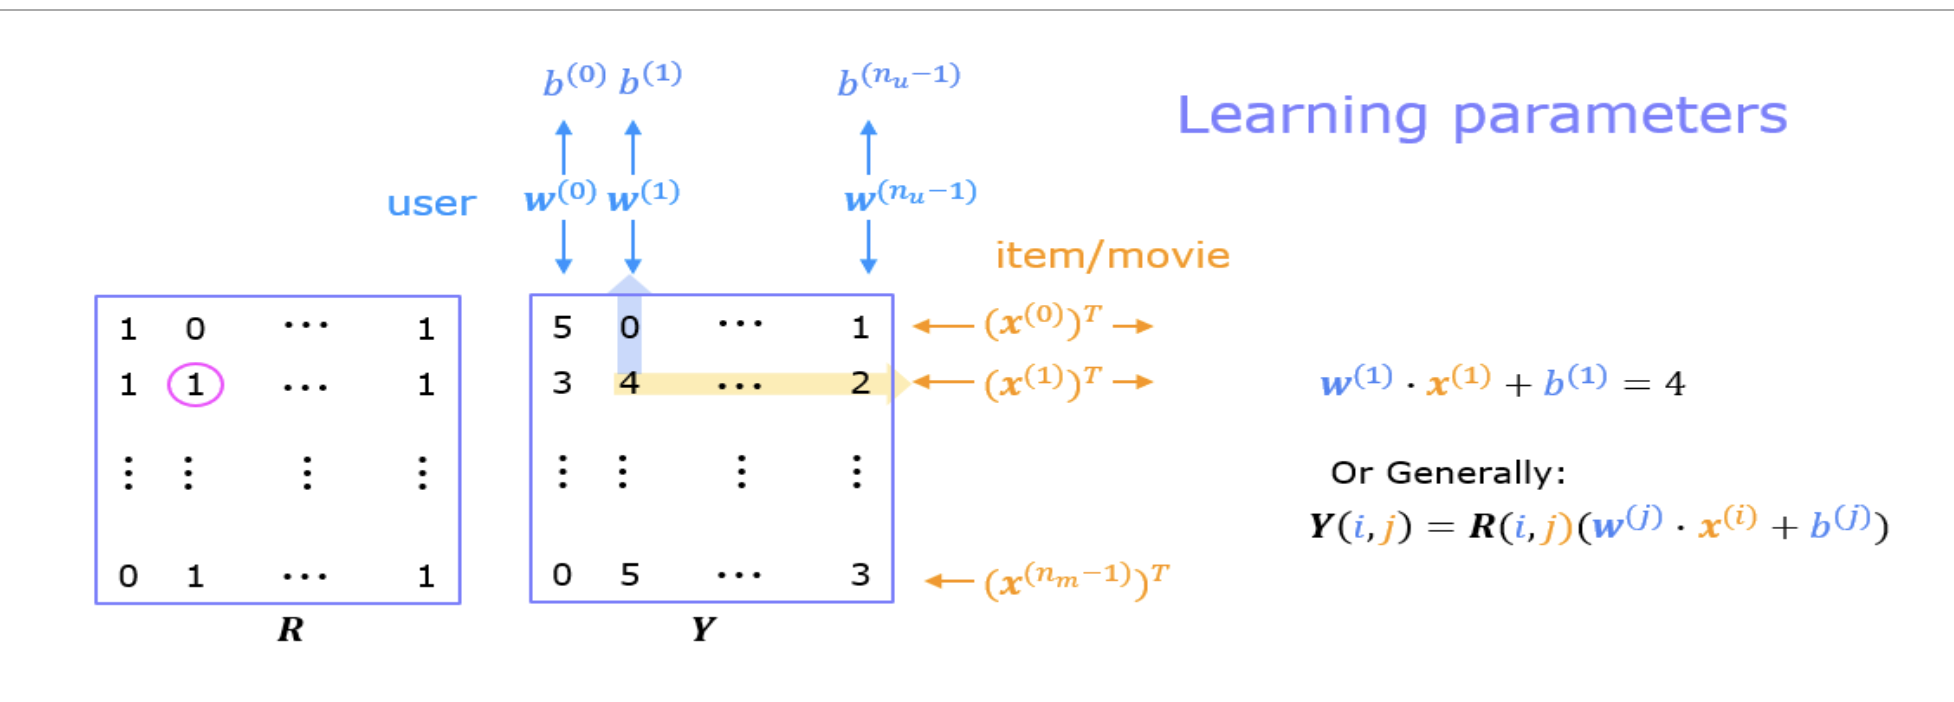
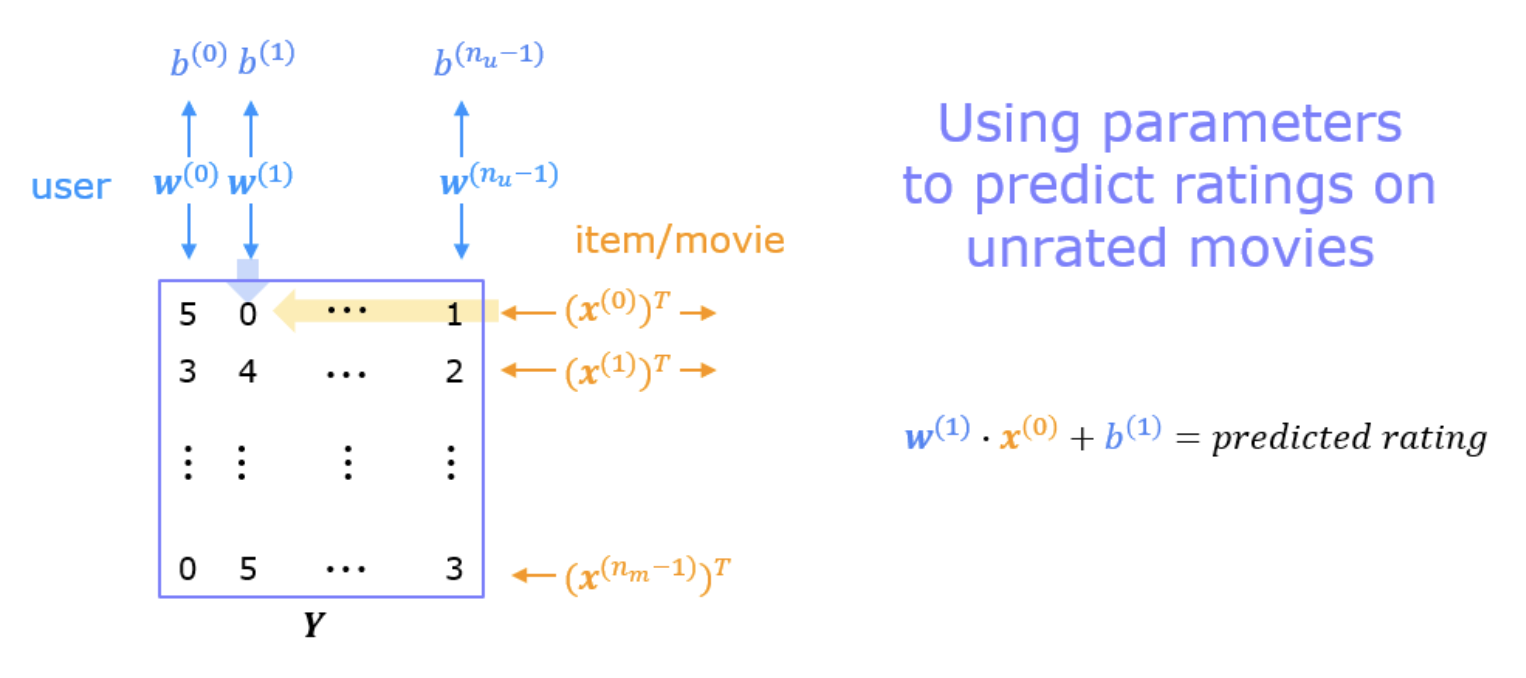
</div>

Below, you will load the movie dataset into the variables  𝑌 and  𝑅

+ The matrix 𝑌 (a 𝑛𝑚×𝑛𝑢 matrix) stores the ratings  𝑦(𝑖,𝑗)
+ The matrix  𝑅 is an binary-valued indicator matrix, where  𝑅(𝑖,𝑗)=1 if user 𝑗 gave a rating to movie  𝑖, and  𝑅(𝑖,𝑗)=0 otherwise.

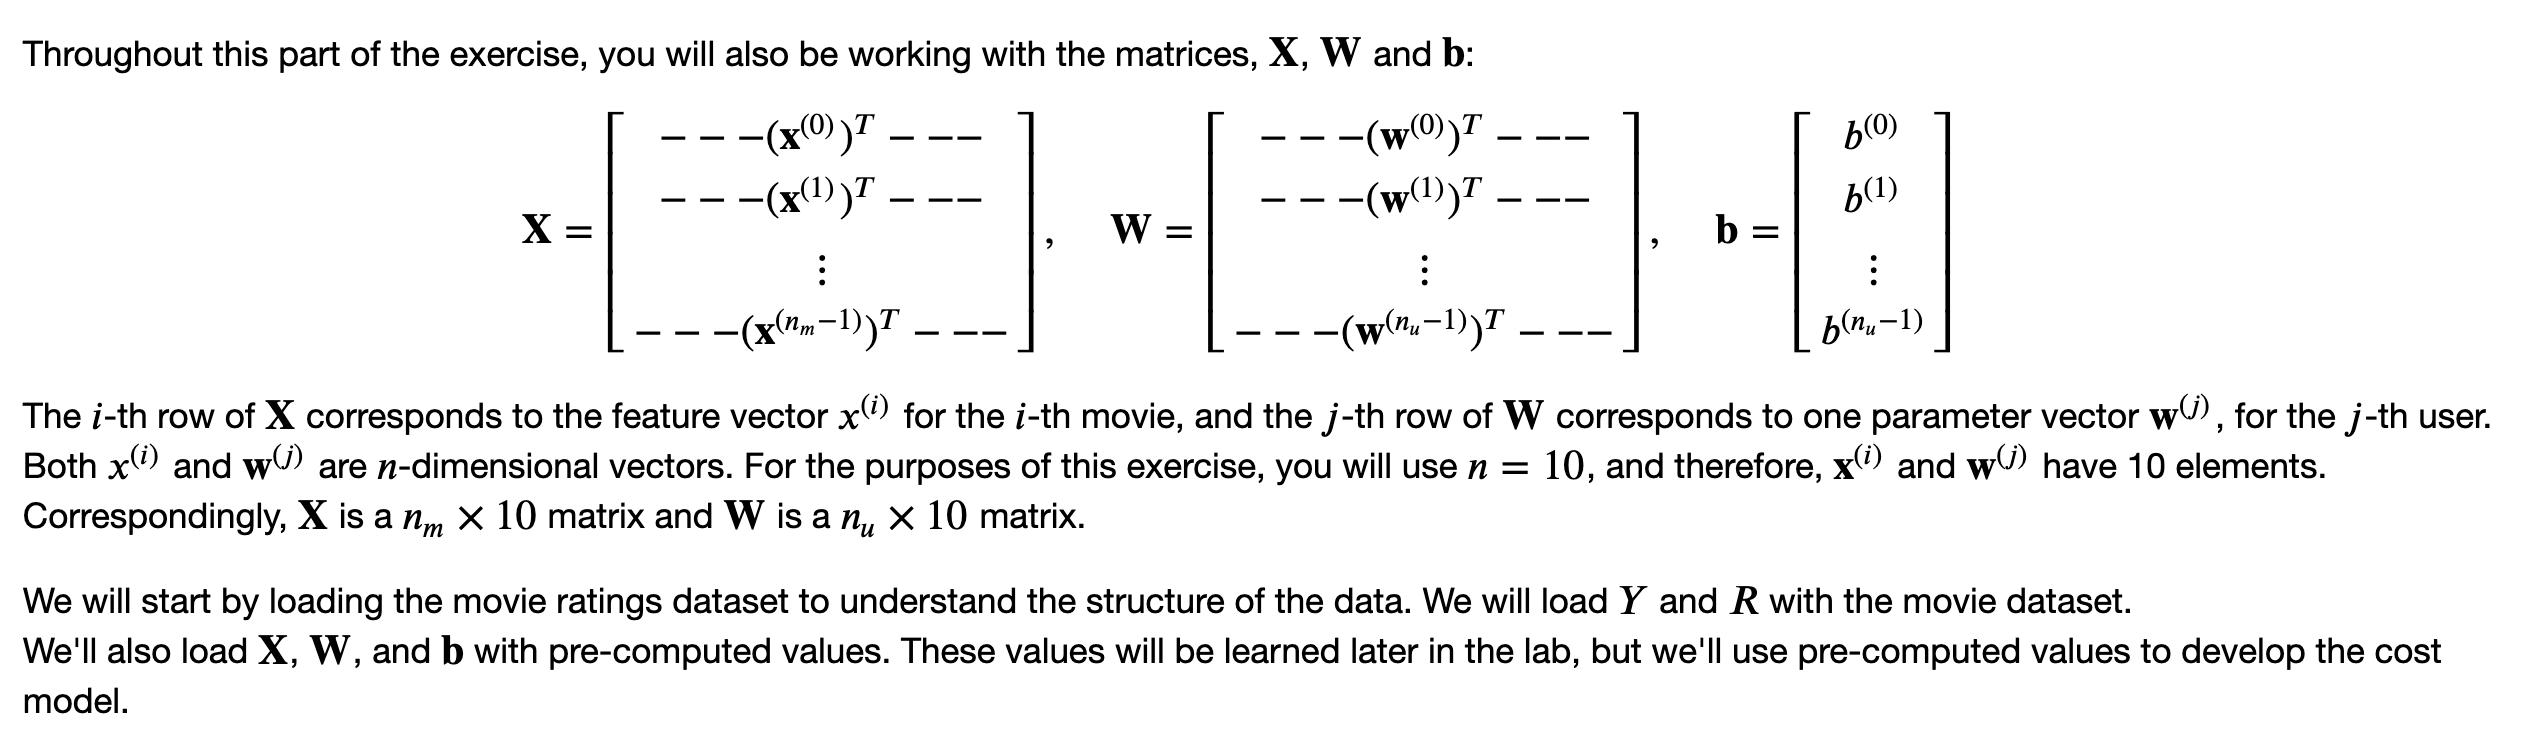

In [231]:
def initialize_param(num_items, num_features, num_users):
    # Set Initial Parameters (W, X), use tf.Variable to track these variables
    tf.random.set_seed(1234)  # for consistent results
    W = tf.Variable(
        tf.random.normal((num_users, num_features), dtype=tf.float64), name="W"
    )
    X = tf.Variable(
        tf.random.normal((num_items, num_features), dtype=tf.float64), name="X"
    )
    b = tf.Variable(
        tf.random.normal((1, num_users), dtype=tf.float64), name="b"
    )
    return X, W, b

In [306]:
df_rating = (
    df_train[["reviewerID", "asin", "overall"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [328]:
rating_matrix = pd.crosstab(
    index=df_rating["reviewerID"],
    columns=df_rating["asin"],
    values=df_rating["overall"],
    aggfunc="max",
)

rating_matrix = rating_matrix.fillna(0)
rating_matrix.head(2)

asin,7106116521,B00007GDFV,B00008JOQI,B00008JPRZ,B00008JQF0,B0000AWX3V,B0002UQASO,B0002Z1JNK,B00062NHH0,B00063VWSA,...,B01HEISONU,B01HFW4U60,B01HFW4YS4,B01HGIDX5M,B01HH37KTG,B01HHVC958,B01HI7FZLQ,B01HI7K476,B01HI9YG0U,B01HJGJ9LS
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00248626G99Y8GVGKKQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A03375698TKTJ5B1TCV3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
np.max(rating_matrix.values), np.min(rating_matrix.values), np.mean(
    rating_matrix.values
)

(5.0, 0.0, 0.0006452172812257404)

In [330]:
Y = rating_matrix.values
R = Y
# Create mask for non-zero values
mask = R != 0
# Replace non-zero values with 1
R[mask] = 1

In [331]:
# Normalize the Dataset
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).
    Only include real ratings R(i,j)=1.
    [Ynorm, Ymean] = normalizeRatings(Y, R) normalized Y so that each movie
    has a rating of 0 on average. Unrated moves then have a mean rating (0)
    Returns the mean rating in Ymean.
    """
    Ymean = (np.sum(Y * R, axis=1) / (np.sum(R, axis=1) + 1e-12)).reshape(
        -1, 1
    )
    Ynorm = Y - np.multiply(Ymean, R)
    return (Ynorm, Ymean)


Ynorm, Ymean = normalizeRatings(Y, R)

## Learning algorithm
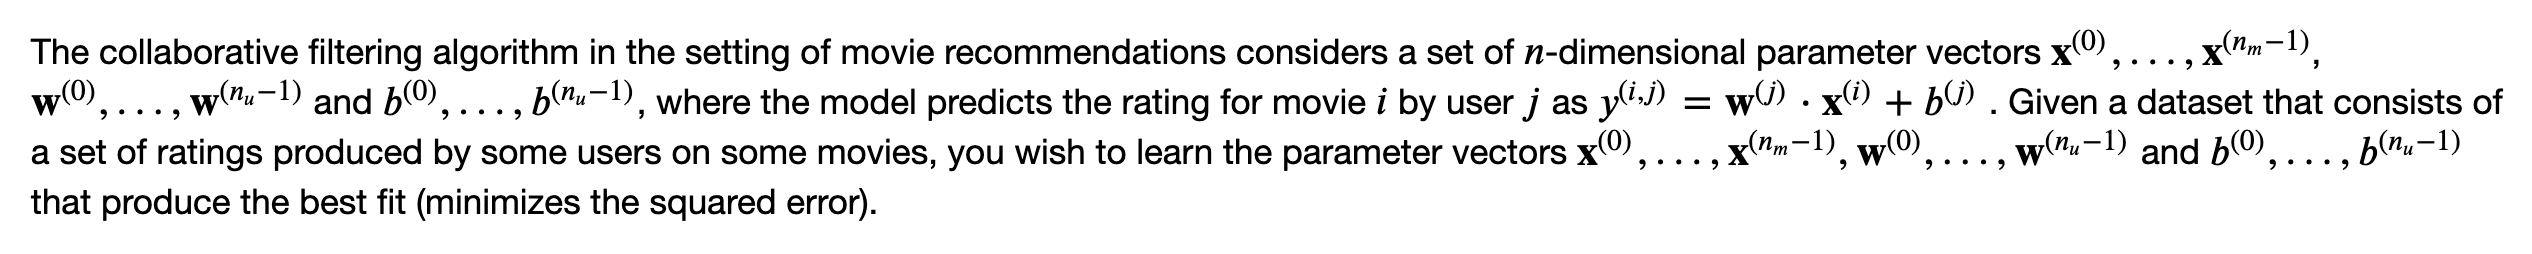

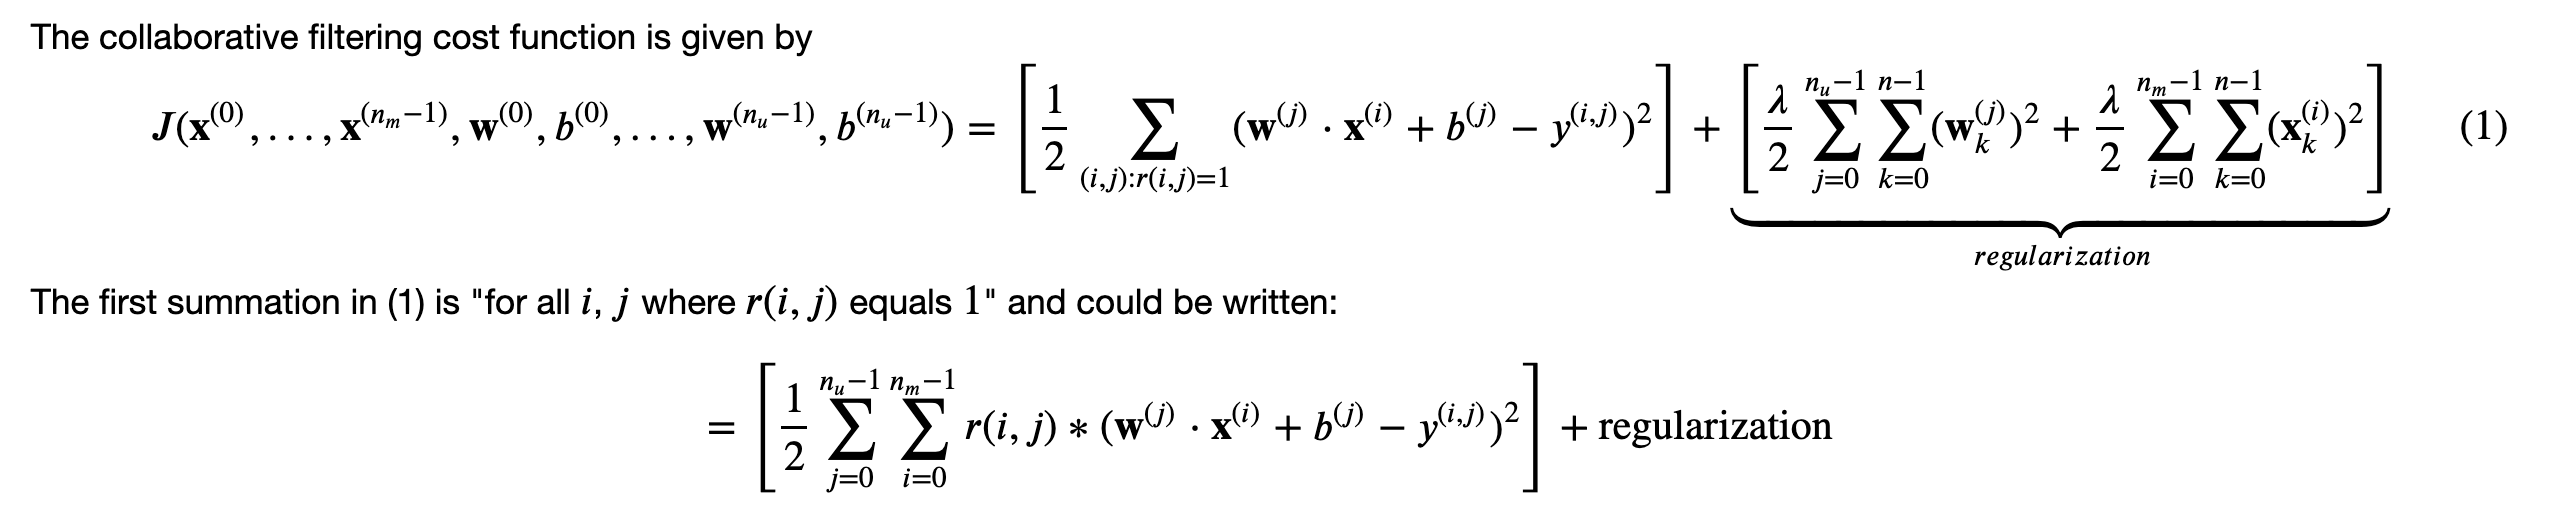

In [332]:
def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Vectorized for speed. Uses tensorflow operations to be compatible with custom training loop.
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_ / 2) * (
        tf.reduce_sum(X**2) + tf.reduce_sum(W**2)
    )
    return J

In [333]:
#  Useful Values
num_items, num_users = Y.shape
num_features = 100
X, W, b = initialize_param(num_items, num_features, num_users)
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-1)

In [334]:
print("Y", Y.shape, "R", R.shape)
print("X", X.shape)
print("W", W.shape)
print("b", b.shape)

print("num_features", num_features)
print("num_movies", num_items)
print("num_users", num_users)

Y (43517, 7867) R (43517, 7867)
X (43517, 100)
W (7867, 100)
b (1, 7867)
num_features 100
num_movies 43517
num_users 7867


In [ ]:
iterations = 200
lambda_ = 1
for iter in range(iterations):
    # Use TensorFlow’s GradientTape
    # to record the operations used to compute the cost
    with tf.GradientTape() as tape:
        # Compute the cost (forward pass included in cost)
        cost_value = cofi_cost_func_v(X, W, b, Ynorm, R, lambda_)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss
    grads = tape.gradient(cost_value, [X, W, b])

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, [X, W, b]))

    # Log periodically.
    if iter % 20 == 0:
        print(f"Training loss at iteration {iter}: {cost_value:0.1f}")

Training loss at iteration 0: 5316163.9
Training loss at iteration 20: 749101.6


## inference

+ Need data about rating from new users
+ Update rating table Y and R

In [319]:
# Make a prediction using trained weights and biases
p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()
# restore the mean
pm = p + Ymean

In [320]:
user_lookup = dict(zip(rating_matrix.index, np.arange(pm.shape[0])))
item_lookup = dict(zip(rating_matrix.columns, np.arange(pm.shape[1])))

In [323]:
def cf_inference(reviewerID, asin, pm):
    return pm[user_lookup[reviewerID], item_lookup[asin]]

In [324]:
y_pred = []
drop_index = []
for row in df_test.itertuples():
    reviewerID = row.reviewerID
    asin = row.asin
    try:
        y_pred.append(pm[user_lookup[reviewerID], item_lookup[asin]])
    except:
        drop_index.append(row.Index)
        print("not lookup")

y_pred = np.array(y_pred)

not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup
not lookup

In [327]:
max(y_pred), min(y_pred), np.mean(y_pred), len(drop_index)

(14.690768646696249, -10.77949457061193, 1.0018108713441531, 1878)

In [298]:
max(y_pred), min(y_pred), np.mean(y_pred)

(8.360377594917715, -7.22327856849002, 0.9797817071442945)

In [326]:
y_true = np.array(df_test["overall"].drop(index=drop_index))
# Return the final RMSE score
rmse(y_true, y_pred)

3.7864548477025615

# Content based method

In [41]:
# Importing libraries for data management
import numpy as np
import numpy.ma as ma
from numpy import genfromtxt
from collections import defaultdict
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option("display.precision", 1)

2023-05-09 15:37:01.614946: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-09 15:37:01.671524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 15:37:43.666628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Generated two vectors
<div>
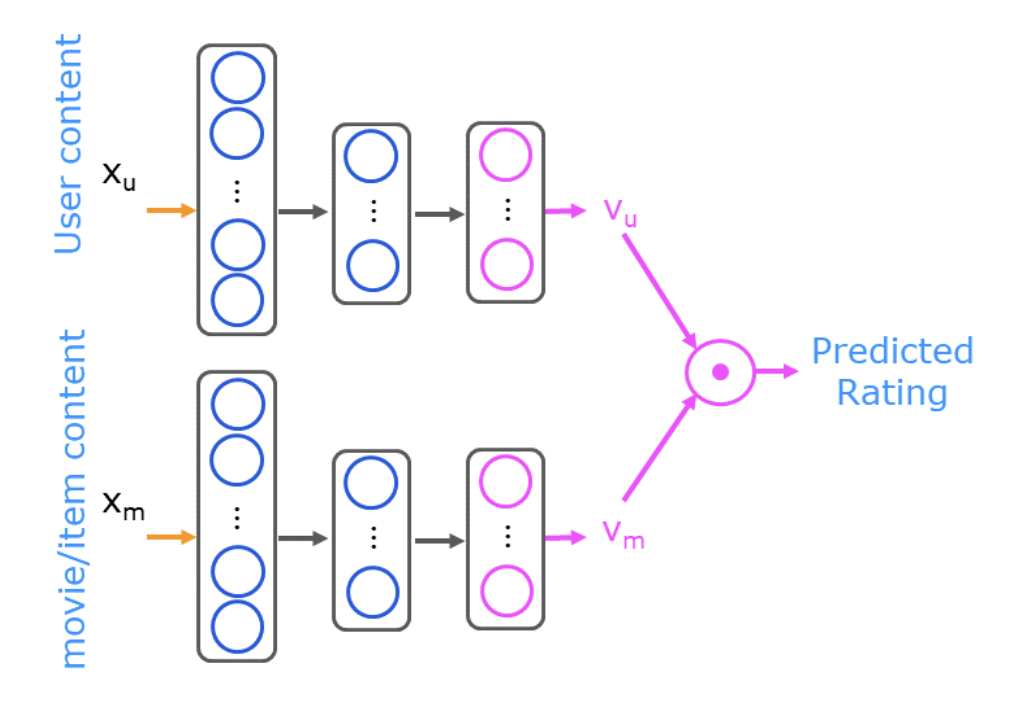
</div>

 + a user vector 
 + an item/movie vector whose dot product would predict a rating. 
 
The vectors can be derived solely from:
 + the ratings: aggregate rating such as: mean, max of each cate
 + other information available about the user and/or movie that may improve the prediction. 

## Derive item vectors

In [108]:
def create_mark_col(df_meta_data_filter, cols):
    for col in cols:
        df_meta_data_filter["Is_" + col] = 1
        df_meta_data_filter.loc[
            df_meta_data_filter[col] == "", "Is_" + col
        ] = 0
    return df_meta_data_filter


df_meta_data_filter = create_mark_col(
    df_meta_data_filter, ["description", "price", "feature", "rank"]
)

/tmp/ipykernel_16309/1363500729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_data_filter["Is_" + col] = 1


In [109]:
item_features = ["brand", "feature", "rank"]

In [110]:
import re


def rank_to_number(text_row):
    text_row = str(text_row)
    if text_row == "":
        return -1
    number = re.findall(r"\d+", text_row)[0]
    return int(number)


def rank_to_text(text_row):
    try:
        text_row = str(text_row)
        if text_row == "":
            return "Unknown"
        text_row = text_row.partition("in")[2].strip()
        return text_row[: text_row.index("(")]
    except:
        return text_row[: text_row.index("&")]

In [111]:
df_meta_data_filter["rank_number"] = df_meta_data_filter["rank"].map(
    rank_to_number
)
df_meta_data_filter["rank_cate"] = df_meta_data_filter["rank"].map(
    rank_to_text
)

/tmp/ipykernel_16309/904464307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_data_filter["rank_number"] = df_meta_data_filter["rank"].map(rank_to_number)
/tmp/ipykernel_16309/904464307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_data_filter["rank_cate"] = df_meta_data_filter["rank"].map(rank_to_text)


In [112]:
from sklearn.preprocessing import LabelEncoder

# Example categorical values
categories = df_meta_data_filter["rank_cate"].unique()
# Create an instance of LabelEncoder
encoder = LabelEncoder()
encoder.fit(categories)

LabelEncoder()

In [113]:
df_meta_data_filter["rank_cate_encode"] = encoder.transform(
    df_meta_data_filter["rank_cate"]
)
items_cols = [
    "asin",
    "Is_description",
    "Is_price",
    "Is_feature",
    "Is_rank",
    "rank_number",
    "rank_cate_encode",
]
df_item_features = (
    df_meta_data_filter[items_cols].drop_duplicates().set_index(["asin"])
)

/tmp/ipykernel_16309/2396139411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_data_filter["rank_cate_encode"] = encoder.transform(df_meta_data_filter["rank_cate"])


## Construct user vector

In [76]:
df_train["count"] = 1
temp1 = df_train.groupby(["reviewerID"]).agg(
    {"overall": "mean", "asin": "nunique"}
)
temp2 = pd.crosstab(
    index=df_train["reviewerID"],
    columns=df_train["overall"],
    values=df_train["count"],
    aggfunc="sum",
).fillna(0)

df_user_features = pd.concat([temp1, temp2], axis=1)

In [77]:
df_user_features.columns = [
    "rating_ave",
    "rating_count",
    "1",
    "2",
    "3",
    "4",
    "5",
]

In [78]:
df_item_features.head(2)

,Is_description,Is_price,Is_feature,Is_rank,rank_number,rank_cate_encode
asin,,,,,,
0764443682,0,0,1,1,13,13
1291691480,0,0,0,1,11,13


In [115]:
def load_data(df_user_features, df_item_features, df_train, df_test):
    user_train = df_user_features.loc[df_train["reviewerID"].values].values
    item_train = df_item_features.loc[df_train["asin"].values].values
    y_train = df_train["overall"].values

    user_test = df_user_features.loc[df_test["reviewerID"].values].values
    item_test = df_item_features.loc[df_test["asin"].values].values
    y_test = df_test["overall"].values

    item_features = df_item_features.columns.tolist()
    user_features = df_user_features.columns.tolist()

    return (
        user_train,
        item_train,
        y_train,
        user_test,
        item_test,
        y_test,
        item_features,
        user_features,
    )

In [134]:
(
    user_train,
    item_train,
    y_train,
    user_test,
    item_test,
    y_test,
    item_features,
    user_features,
) = load_data(df_user_features, df_item_features, df_train, df_test)

In [135]:
user_train.shape, item_train.shape, y_train.shape

((56264, 7), (56264, 6), (56264,))

In [136]:
user_test.shape, item_test.shape, y_test.shape

((46035, 7), (46035, 6), (46035,))

In [137]:
y_train

array([5., 1., 1., ..., 5., 3., 5.])

In [138]:
y_test

array([5., 3., 5., ..., 2., 5., 1.])

## Prepare training data

In [139]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
# ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(
    np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train))
)
print(
    np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train))
)

True
True


In [142]:
# Trainsform for test
item_test = scalerItem.transform(item_test)
user_test = scalerUser.transform(user_test)
y_test = scalerTarget.transform(y_test.reshape(-1, 1))
# ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

## Neural network for content based

In [143]:
num_user_features = len(user_features)
num_item_features = len(item_features)

In [144]:
user_features, item_features

(['rating_ave', 'rating_count', '1', '2', '3', '4', '5'],
 ['Is_description',
  'Is_price',
  'Is_feature',
  'Is_rank',
  'rank_number',
  'rank_cate_encode'])

In [145]:
# GRADED_CELL
# UNQ_C1

num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs, activation="linear"),
        ### END CODE HERE ###
    ]
)

item_NN = tf.keras.models.Sequential(
    [
        ### START CODE HERE ###
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs, activation="linear"),
        ### END CODE HERE ###
    ]
)

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = keras.Model([input_user, input_item], output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 32)           39072       ['input_5[0][0]']                
                                                                                                  
 sequential_7 (Sequential)      (None, 32)           38816       ['input_6[0][0]']                
                                                                                            

In [146]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss=cost_fn)

model.fit([user_train, item_train], y_train, epochs=20)

Epoch 1/20
1759/1759 [==============================] - 5s 2ms/step - loss: 0.0449
Epoch 2/20
1759/1759 [==============================] - 4s 3ms/step - loss: 0.0413
Epoch 3/20
1759/1759 [==============================] - 4s 3ms/step - loss: 0.0409
Epoch 4/20
1759/1759 [==============================] - 4s 2ms/step - loss: 0.0406
Epoch 5/20
1759/1759 [==============================] - 4s 2ms/step - loss: 0.0406
Epoch 6/20
1759/1759 [==============================] - 4s 3ms/step - loss: 0.0402
Epoch 7/20
1759/1759 [==============================] - 4s 2ms/step - loss: 0.0402
Epoch 8/20
1759/1759 [==============================] - 4s 2ms/step - loss: 0.0400
Epoch 9/20
1759/1759 [==============================] - 4s 2ms/step - loss: 0.0399
Epoch 10/20
1759/1759 [==============================] - 4s 2ms/step - loss: 0.0396
Epoch 11/20
1759/1759 [==============================] - 4s 2ms/step - loss: 0.0396
Epoch 12/20
1759/1759 [==============================] - 4s 2ms/step - loss: 0.0395
E

In [147]:
model.evaluate([user_train, item_train], y_train), model.evaluate(
    [user_test, item_test], y_test
)

1439/1439 [==============================] - 2s 1ms/step - loss: 0.3723


(0.038905952125787735, 0.3723351061344147)

In [148]:
y_pred = model.predict([user_test, item_test])
y_pred_orig = scalerTarget.inverse_transform(y_pred.reshape(-1, 1))

1439/1439 [==============================] - 2s 1ms/step


In [150]:
get_score_model(y_pred_orig, df_test)

1.2203852450946044

## Finding similar item

In [ ]:
item_vecs = df_item_features.values

In [151]:
# GRADED_FUNCTION: sq_dist
# UNQ_C2


def sq_dist(a, b):
    """
    Returns the squared distance between two vectors
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """
    ### START CODE HERE ###
    d = sum(np.square(a - b))
    ### END CODE HERE ###
    return d

In [170]:
a1 = np.array([1.0, 2.0, 3.0])
b1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([1.1, 2.1, 3.1])
b2 = np.array([1.0, 2.0, 3.0])
a3 = np.array([0, 1, 0])
b3 = np.array([1, 0, 0])
print(f"squared distance between a1 and b1: {sq_dist(a1, b1):0.3f}")
print(f"squared distance between a2 and b2: {sq_dist(a2, b2):0.3f}")
print(f"squared distance between a3 and b3: {sq_dist(a3, b3):0.3f}")

squared distance between a1 and b1: 0.000
squared distance between a2 and b2: 0.030
squared distance between a3 and b3: 2.000


Once you have a movie model, you can create a set of movie feature vectors by using the model to predict using a set of item/movie vectors as input. `item_vecs` is a set of all of the movie vectors. It must be scaled to use with the trained model. The result of the prediction is a 32 entry feature vector for each movie.

In [171]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))  # input layer
vm_m = item_NN(input_item_m)  # use the trained item_NN
vm_m = tf.linalg.l2_normalize(
    vm_m, axis=1
)  # incorporate normalization as was done in the original model
model_m = tf.keras.Model(input_item_m, vm_m)
model_m.summary()

scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs)
print(f"size of all predicted movie feature vectors: {vms.shape}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 6)]               0         
                                                                 
 sequential_7 (Sequential)   (None, 32)                38816     
                                                                 
 tf.math.l2_normalize_7 (TFO  (None, 32)               0         
 pLambda)                                                        
                                                                 
Total params: 38,816
Trainable params: 38,816
Non-trainable params: 0
_________________________________________________________________


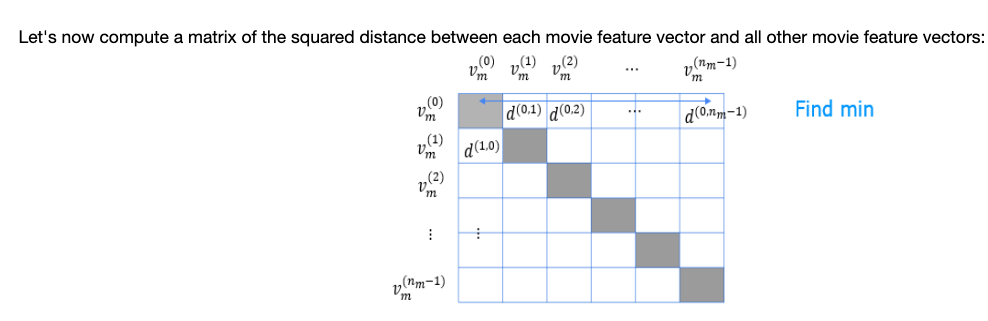

In [180]:
count = 10  # number of movies to display
dim = len(vms)
dist = np.zeros((dim, dim))

for i in range(dim):
    for j in range(dim):
        dist[i, j] = sq_dist(vms[i, :], vms[j, :])

m_dist = ma.masked_array(
    dist, mask=np.identity(dist.shape[0])
)  # mask the diagonal

KeyboardInterrupt: 